In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [2]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [3]:
mx = 0; root = None
for u in range(N):
    if get_size(G, [0] * N, u) > mx:
        mx = get_size(G, [0] * N, u)
        root = u
        
print(root, get_size(G, [0] * N, root), N)

744 4586 4586


In [4]:
def visit_robust(G, V, root, u):
    
    N = len(V)
    I = get_ideal_robust(G, V, root, u)
    
    VI = [0] * N
    for u in I:
        VI[u] = 1
    
    return [bool(VI[u] + V[u]) for u in range(N)], sum([(VI[u] and not V[u]) for u in range(N)])

def get_size_precalc_robust(G, W, V_, root, u):
    
    I = set(get_ideal_robust(G, V_, root, u))
    
    if V_[u]:
        return 0
    
    if W[u] <= 200:
        return 1
    
    V = V_.copy()
    
    s = 1; V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v in I:
                s += 1; V[v] = 1
                if W[v] > 200:
                    Q.append(v)
                    I.remove(v)
    
    return s

def greedyAppReduceDynamicRobust(G, W, V_, root, K, limit, wlim):
    
    V = V_.copy(); N = len(V)
    E = {u for u in range(N) if not V[u]}

    ans = []; tot = 0
    while len(ans) < K:
        
        S = [0 for u in range(N)]
        for v in E:
            _, S[v] = get_size_weight_robust(G, W, V, root, v)
        
        maxv = 0; u = -1
        for v in E:
            s = get_size_precalc_robust(G, S, V, root, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break
        
        V, x = visit_robust(G, V, root, u)
        ans.append(u); tot += x
        E.remove(u)
        
    return ans, tot

In [5]:
def plot_sample_no_intersections(G, V_, sample, geom, _id):
    
    geometry = geom.copy(); N = len(V_)
    
    V = V_.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            C[u] = i + 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(sample) - 2]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                       figsize=(15, 15),
                       legend = True,
                       legend_kwds={'label': "-1: No considerado \n 0: No cubierto ", 'orientation': "horizontal"},
                       cmap = 'nipy_spectral',)
    plt.show()

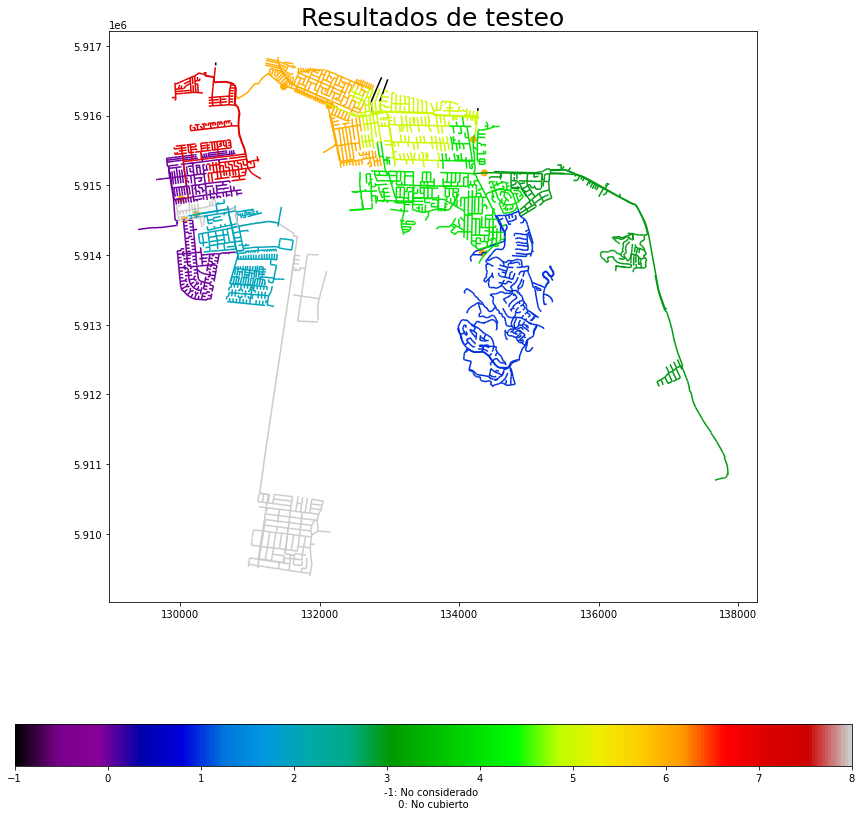

In [6]:
# low = 0; high = N
# while low != high:
#     mid = (low + high) // 2
#     P, sP = greedyAppReduceDynamic(G, W, [0] * N, 8, mid, 1e8)
#     if N - sP < mid:
#         high = mid
#     else:
#         low = mid + 1
        
low = 362
init_P, _ = greedyAppReduceDynamic(G, W, [0] * N, 8, low - 1, 1e8)

plot_sample_no_intersections(G, [0] * N, init_P, geometry, _id)

In [7]:
def simulate_robust(G, W, k2, S, verbose):
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); P = []; sP = 0
            
            if verbose:
                print("it,", t, R)
            
            if t == 0:
                P = init_P
            elif R >= 10:
                low = 0; high = R
                while low != high:
                    mid = (low + high) // 2
                    P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, mid, 1e8)
                    if R - sP < mid:
                        high = mid
                    else:
                        low = mid + 1
                P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, low, 1e8)
                
                if low > 1:
                    P_, sP_ = greedyAppReduceDynamicRobust(G, W, V, root, k2, low - 1, 1e8)
                    
                    if verbose:
                        print("low:", low, R - sP, R - sP_)
                    
                    if abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or (len(P) == 1 and sP == R):
                        P = P_; sP = sP_
            else:
                P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, 1, 1e8)
    
            if verbose:
                plot_sample_no_intersections(G, V, P, geometry, _id)
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal_robust(G, V, root, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)
            weight = sum([W[u] for u in range(N) if not V[u]])
            
            if verbose:
                print(size, weight)

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [66]:
iters = simulate_robust(G, W, 5, random.sample(range(N), 50), False)
# simulate_robust(G, W, 5, [510], True)

Result 2347: 3    acc: 3.0
Result 3811: 4    acc: 3.5
Result 1379: 5    acc: 4.0
Result 1862: 5    acc: 4.25
Result 2805: 5    acc: 4.4
Result 52: 6    acc: 4.666666666666667
Result 1233: 5    acc: 4.714285714285714
Result 1787: 5    acc: 4.75
Result 3273: 5    acc: 4.777777777777778
Result 1592: 4    acc: 4.7
Result 3374: 10    acc: 5.181818181818182
Result 369: 5    acc: 5.166666666666667
Result 3161: 5    acc: 5.153846153846154
Result 3796: 4    acc: 5.071428571428571
Result 4153: 4    acc: 5.0
Result 2646: 4    acc: 4.9375
Result 1087: 4    acc: 4.882352941176471
Result 1641: 3    acc: 4.777777777777778
Result 1044: 4    acc: 4.7368421052631575
Result 1210: 4    acc: 4.7
Result 4430: 5    acc: 4.714285714285714
Result 3936: 6    acc: 4.7727272727272725
Result 2704: 6    acc: 4.826086956521739
Result 152: 5    acc: 4.833333333333333
Result 1330: 4    acc: 4.8
Result 3530: 4    acc: 4.769230769230769
Result 796: 5    acc: 4.777777777777778
Result 1789: 6    acc: 4.821428571428571
Res

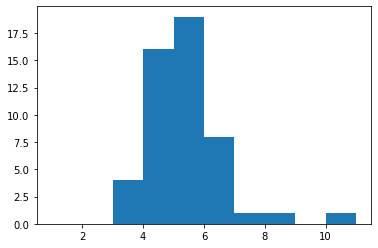

In [67]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [8]:
def greedyAppReduceDynamicRobustFilter(G, W, V_, root, K, limit, wlim, plim):
    
    V = V_.copy(); N = len(V)

    ans = []; tot = 0
    while len(ans) < K:
        
        E_ = []
        
        S = [0 for u in range(N)]
        for v in range(N):
            if not V[v]:
                s = get_size(G, V, v)
                _, S[v] = get_size_weight_robust(G, W, V, root, v)
                if (S[v] / s) >= plim:
                    E_.append(v)
        
        maxv = 0; u = -1
        for v in E_:
            s = get_size_precalc_robust(G, S, V, root, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            
            maxv = 0; u = -1
            for v in range(N):
                if not V[v]:
                    s = get_size_precalc_robust(G, S, V, root, v)
                    if s > maxv and s <= limit and S[v] <= wlim:
                        u = v
                        maxv = s
            
            if u == -1:
                break
        
        V, x = visit_robust(G, V, root, u)
        ans.append(u); tot += x
        
    return ans, tot

In [9]:
def simulate_robust_filter(G, W, k2, S, plim, verbose):
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); P = []; sP = 0
            
            if verbose:
                print("it,", t, R)
            
            if t == 0:
                P = init_P
            elif R >= 10:
                low = 0; high = R
                while low != high:
                    mid = (low + high) // 2
                    P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, mid, 1e8, plim)
                    if R - sP < mid:
                        high = mid
                    else:
                        low = mid + 1
                P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, low, 1e8, plim)
                
                if low > 1:
                    P_, sP_ = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, low - 1, 1e8, plim)
                    
                    if verbose:
                        print("low:", low, R - sP, R - sP_)
                    
                    if abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or (len(P) == 1 and sP == R):
                        P = P_; sP = sP_
            else:
                P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, 1, 1e8, plim)
    
            if verbose:
                plot_sample_no_intersections(G, V, P, geometry, _id)
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal_robust(G, V, root, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)
            weight = sum([W[u] for u in range(N) if not V[u]])
            
            if verbose:
                print(size, weight)

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [10]:
SS = random.sample(range(N), 50)

In [ ]:
iters = simulate_robust_filter(G, W, 5, SS, 1, False)

Result 2716: 5    acc: 5.0
Result 1263: 4    acc: 4.5
Result 2584: 4    acc: 4.333333333333333
Result 2039: 5    acc: 4.5
Result 1494: 4    acc: 4.4
Result 2683: 5    acc: 4.5
Result 2410: 6    acc: 4.714285714285714
Result 3926: 5    acc: 4.75
Result 2439: 5    acc: 4.777777777777778
Result 313: 6    acc: 4.9
Result 246: 3    acc: 4.7272727272727275
Result 4328: 7    acc: 4.916666666666667
Result 535: 4    acc: 4.846153846153846
Result 2094: 5    acc: 4.857142857142857
Result 2190: 5    acc: 4.866666666666666
Result 4004: 4    acc: 4.8125
Result 2640: 7    acc: 4.9411764705882355
Result 1988: 4    acc: 4.888888888888889
Result 3441: 5    acc: 4.894736842105263
Result 4241: 5    acc: 4.9
Result 998: 4    acc: 4.857142857142857
Result 2624: 6    acc: 4.909090909090909
Result 2349: 5    acc: 4.913043478260869
Result 3048: 5    acc: 4.916666666666667
Result 848: 3    acc: 4.84
Result 4375: 5    acc: 4.846153846153846
Result 827: 5    acc: 4.851851851851852
Result 1668: 7    acc: 4.9285714

In [ ]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [ ]:
iters = simulate_robust_filter(G, W, 5, SS, 0.8, False)

In [ ]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [ ]:
iters = simulate_robust_filter(G, W, 5, SS, 0.6, False)

In [ ]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [ ]:
iters = simulate_robust_filter(G, W, 5, SS, 0.4, False)

In [ ]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [ ]:
iters = simulate_robust_filter(G, W, 5, SS, 0.2, False)

In [ ]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [ ]:
iters = simulate_robust_filter(G, W, 5, SS, 0, False)

In [ ]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()